In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [37]:
class replay_memory(Dataset):
    def __init__(self):
        self.state_0 = []
        self.state_1 = []
        self.reward = []
        self.action = []

    def append_(self,state0, state1, reward, action):
        self.state_0.append(state0)
        self.state_1.append(state1)
        self.reward.append(reward)
        self.action.append(action)

    def __len__(self):
        return len(self.state_0)

    def __getitem__(self,idx):
        return (self.state_0[idx],self.state_1[idx],
                 self.reward[idx], self.action[idx])
    
    def remove(self):
        self.state_0.pop(0)
        self.state_1.pop(0)
        self.reward.pop(0)
        self.action.pop(0)

    def sample(self, batch_size):
        idx = sorted(np.arange(len(self.state_0)))
        idx_sample = random.sample(idx, batch_size)

        return (torch.tensor([self.state_0[i]for i in idx_sample]),
                torch.tensor([self.state_1[i]for i in idx_sample]),
                torch.tensor([self.reward[i] for i in idx_sample]),
                torch.tensor([self.action[i] for i in idx_sample]))

class qnet(nn.Module):
    def __init__(self,state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.l1 = nn.Linear(state_dim,128)
        self.l2 = nn.Linear(128,128)
        self.l3 = nn.Linear(128,self.action_dim)

        self.activation = nn.ReLU()

    def forward(self,x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

def train(iterations, copy_period, batch_size, discount, random_action_p_start, random_action_p_end, verbose=False):

    target_net = qnet(state_dim=4, action_dim=2)
    policy_net = qnet(state_dim=4, action_dim=2)

    target_net.eval()
    policy_net.train()

    optimizer = optim.AdamW(policy_net.parameters(), lr=1e-4, amsgrad=True)
    Huber = nn.SmoothL1Loss()

    policy_net.load_state_dict(target_net.state_dict())

    replay = replay_memory()
  
    observation, info = env.reset(seed=42)
    stop = 0
    random_action_p = random_action_p_start
    progress = []

    for i in range(iterations):

        random_action_p = random_action_p - (random_action_p_start-random_action_p_end)/iterations

        if random.random()<random_action_p:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = policy_net(torch.tensor(observation).reshape(1,-1))
            action = torch.argmax(q_values).item()

        observation_, reward, terminated, truncated, info = env.step(action)

        # If the episode has ended then we can reset to start a new episode
        if terminated or truncated:
            replay.append_(observation, observation_, 0, action)
            progress.append(i-stop)
            stop = i
            observation, info = env.reset()
        else:
            replay.append_(observation, observation_, reward, action)
            observation = observation_


        if len(replay)>batch_size and i%(batch_size)==0:
            optimizer.zero_grad()
            sample = replay.sample(batch_size)
            out = policy_net(sample[0])

            q_state = out[torch.arange(batch_size), sample[3]]

            with torch.no_grad():
                q_next_state_max, _ = torch.max(target_net(sample[1]),dim=1)

            mask = sample[2]==1

            Loss = Huber(q_state, (sample[2] + discount*q_next_state_max*mask))

            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
            Loss.backward()
            optimizer.step()

            if verbose and i%4000==0:
                print(f"iteration: {i}, exploration: {random_action_p:2.3f} loss: {Loss:2.3f}, progress: {sum(progress[-10:])/10}")

        if i%copy_period==0:
            target_net.load_state_dict(policy_net.state_dict())

        if len(replay)>5000:
            replay.remove()
    #plt.plot(progress, color="green")
    smoothed_x = np.arange(5,len(progress)-5)
    smoothed = [np.mean(progress[i-5:i+5]) for i in smoothed_x]
    plt.plot(smoothed_x,smoothed, color="red")
    plt.title("games played vs duration before fail")
    plt.ylabel("game-duration")
    plt.xlabel("games played")
    plt.show()



iteration: 4000, exploration: 0.792 loss: 0.440, progress: 18.9
iteration: 8000, exploration: 0.785 loss: 0.309, progress: 16.8
iteration: 12000, exploration: 0.777 loss: 0.223, progress: 14.0
iteration: 16000, exploration: 0.770 loss: 0.007, progress: 16.1
iteration: 20000, exploration: 0.762 loss: 0.269, progress: 16.3
iteration: 24000, exploration: 0.755 loss: 0.226, progress: 28.1
iteration: 28000, exploration: 0.747 loss: 0.005, progress: 31.9
iteration: 32000, exploration: 0.740 loss: 0.004, progress: 33.3
iteration: 36000, exploration: 0.732 loss: 0.177, progress: 24.3
iteration: 40000, exploration: 0.725 loss: 0.001, progress: 34.9
iteration: 44000, exploration: 0.717 loss: 0.004, progress: 45.0
iteration: 48000, exploration: 0.710 loss: 0.079, progress: 45.0
iteration: 52000, exploration: 0.702 loss: 0.001, progress: 39.8
iteration: 56000, exploration: 0.695 loss: 0.001, progress: 38.0
iteration: 60000, exploration: 0.687 loss: 0.001, progress: 58.9
iteration: 64000, explorati

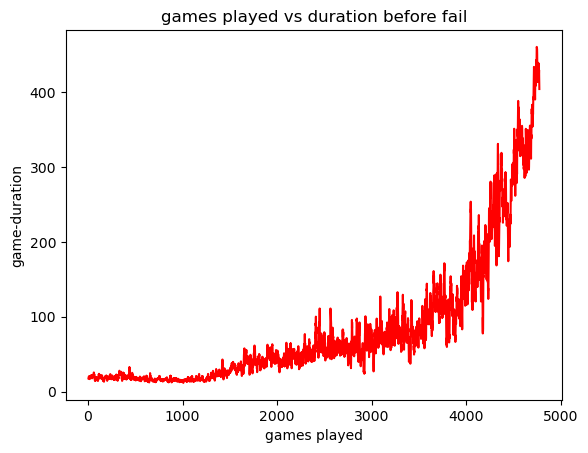

In [38]:
iterations = 400000
copy_period = 50
batch_size = 32
gamma = 0.7
start = 0.8
end = 0.05

train(iterations,copy_period,batch_size,gamma,start,end,True)